# PSF Photometry and Isochrones

Some useful resources:

https://theprometheus.readthedocs.io/en/latest/

https://thechronos.readthedocs.io/en/latest/

Packages you need to pip install:
* prometheus (pip install theprometheus)
* chronos (pip install thechronos)

Files you will need:
* image.fits
* isochrone_data.zip

In [2]:
# imports
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from astropy.table import Table
from dlnpyutils import coords
import prometheus
from chronos import chronos
%matplotlib inline

# PSF Photometry with Prometheus

In [16]:
from prometheus import ccddata,prometheus,models
from prometheus.ccddata import CCDData

In [17]:
image = CCDData.read('image.fits')

In [18]:
image

CCDData([[6690.645 , 6649.7256, 6629.9736, ..., 6607.448 , 6654.932 ,
          6709.3467],
         [6553.6343, 6662.985 , 6645.0073, ..., 6664.3984, 6624.5225,
          6599.72  ],
         [6638.526 , 6616.5605, 6697.084 , ..., 6582.6406, 6682.436 ,
          6772.4287],
         ...,
         [6764.22  , 6710.4526, 6666.8896, ..., 6575.875 , 6663.582 ,
          6666.895 ],
         [6772.0825, 6583.253 , 6678.261 , ..., 6584.5234, 6688.158 ,
          6687.9243],
         [6672.346 , 6655.838 , 6615.8877, ..., 6662.5093, 6608.6963,
          6757.5405]])
BoundingBox(ixmin=0, ixmax=500, iymin=0, iymax=500)

In [19]:
image.sky

array([[6644.2627, 6644.273 , 6644.283 , ..., 6657.5186, 6657.4287,
        6657.339 ],
       [6644.3613, 6644.372 , 6644.381 , ..., 6657.519 , 6657.429 ,
        6657.3394],
       [6644.46  , 6644.47  , 6644.479 , ..., 6657.5234, 6657.4326,
        6657.3423],
       ...,
       [6652.154 , 6652.252 , 6652.3506, ..., 6647.467 , 6647.3926,
        6647.32  ],
       [6652.1553, 6652.255 , 6652.355 , ..., 6647.4517, 6647.3784,
        6647.3047],
       [6652.157 , 6652.2573, 6652.3584, ..., 6647.4375, 6647.363 ,
        6647.289 ]], dtype=float32)

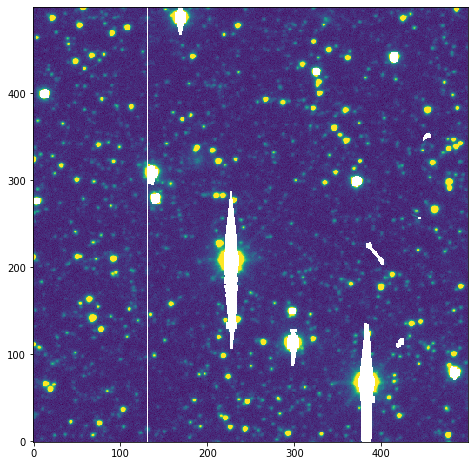

In [20]:
fig = plt.figure(figsize=(8,8))
plt.imshow(image,origin='lower',vmax=8000)

## Construct an initial PSF model

In [21]:
# input parameters are [sigma_x,sigma_y,theta]
psf = models.PSFGaussian([3.5,4.5,1.0])

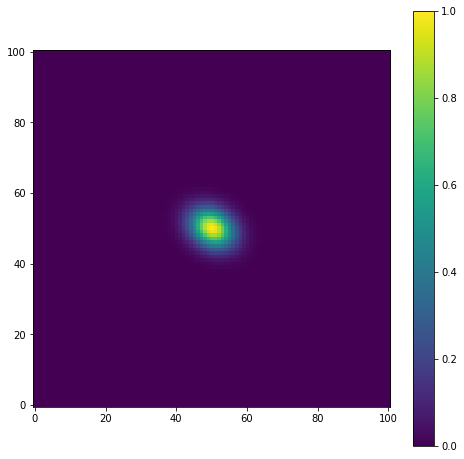

In [22]:
# Plot up the PSF image
fig = plt.figure(figsize=(8,8))
plt.imshow(psf(),origin='lower')
plt.colorbar()

## let's fit a single star

(0, 60)

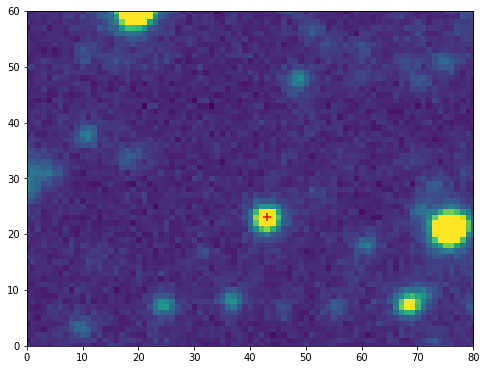

In [23]:
fig = plt.figure(figsize=(8,8))
plt.imshow(image,origin='lower',vmax=8000)
plt.scatter([43],[23],c='r',marker='+',s=50)
plt.xlim(0,80)
plt.ylim(0,60)

## We can easily do this by using the ``psf.fit()`` method.

In [24]:
# [height,xcen,ycen]
out,model = psf.fit(image,[100,43,23])

In [25]:
Table(out)

id,height,height_error,x,x_error,y,y_error,sky,sky_error,flux,flux_error,mag,mag_error,niter,nfitpix,rms,chisq
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,float64,float64
1,695.9585281162299,54.886272709669356,43.00190797388927,0.3471755697452482,22.826772327588024,0.3127652470702214,6572.243219667995,17.80958889223734,6828.57108824442,538.5303862590983,15.41417541261701,0.0856258110471258,2,441,0.3201819775442034,522.7828969101922


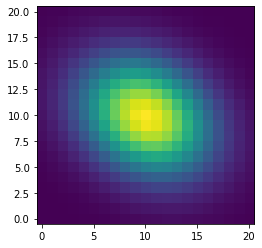

In [26]:
plt.imshow(model,origin='lower')

## Let's fit the PSF to a number of isolated stars

In [27]:
from prometheus import detection,aperture,utils
# Initial source detection
objects = detection.detect(image)
print(len(objects),' objects')
# Measure aperture photometry (not totally necessary)
objects = aperture.aperphot(image,objects)
# Estiomate the FWHM using the morphology parameters
fwhm = utils.estimatefwhm(objects,verbose=True)
# Pick good, isolated stars to fit the PSF
psfobj = utils.pickpsfstars(objects,fwhm,verbose=True)

1102  objects
FWHM =  4.15 pixels (99 sources)
Too few PSF stars on first try. Loosening cuts
62 PSF stars found


In [28]:
# Now we construct an initial PSF model, and run ``getpsf``
from prometheus import getpsf
initpsf=models.psfmodel('gaussian',[fwhm/2.35,0.9*fwhm/2.35,0.0],binned=False)
newpsf,pars,perror,psfcat = getpsf.getpsf(initpsf,image,psfobj,verbose=True) 

Removing 3 stars near the edge
--- Iteration 1 ---
  Fitting radius = 4.020
  pars =  [1.76587692 1.58928923 0.        ]
  dbeta =  [-0.04664178  0.00308488  0.17500937]
   2 [1.71923515 1.59237411 0.17500937] 17.500937465352703 76660.35969362037
  pars =  [1.71923515 1.59237411 0.17500937]
  dbeta =  [-0.0050739  -0.01728572  0.06062299]
   3 [1.71416124 1.57508839 0.23563237] 34.639854619146526 68061.08141444644
  pars =  [1.71416124 1.57508839 0.23563237]
  dbeta =  [-0.00500747 -0.00571915 -0.00476917]
   4 [1.70915377 1.56936925 0.23086319] 2.023988887955984 65152.11345100628
  pars =  [1.70915377 1.56936925 0.23086319]
  dbeta =  [-0.00286962 -0.00266028 -0.00031499]
   5 [1.70628415 1.56670897 0.2305482 ] 0.16951274937694816 63909.46684613567
Best-fitting parameters:  [1.70628415 1.56670897 0.2305482 ]
Errors:  [0.005287   0.00471933 0.0291575 ]
Median RMS:  0.0720950462496742
dt = 0.59 sec
dt = 0.60 sec


In [29]:
newpsf

PSFGaussian([1.7062841474631405, 1.5667089657524924, 0.23054820186176367],binned=False)

## Now let's fit that star again

In [30]:
out2,model2 = newpsf.fit(image,[100,43,23])

In [31]:
Table(out2)

id,height,height_error,x,x_error,y,y_error,sky,sky_error,flux,flux_error,mag,mag_error,niter,nfitpix,rms,chisq
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,float64,float64
1,2218.101548596866,45.8931996411357,42.89566652184136,0.0373609091993781,22.79893771151233,0.03456596741835499,6646.292396892122,13.728529159916024,8669.303270645558,179.37053693550155,15.155039510598026,0.0224642142439755,2,81,0.04460670781273368,45.2815180505034


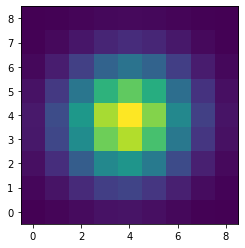

In [32]:
plt.imshow(model2,origin='lower')

<font color='blue'>
    <h1>In-class Exercise:</h1>

1) Pick a star in the image and determine its central coordinates.
    
2) Fit the PSF to it using ``psf.fit()``.
 
3) Plot the star in the original image (zoom in), and the model, side-by-side.

</font>

## Run all steps

In [33]:
from prometheus import prometheus
out,model,sky,psf = prometheus.run(image,'gaussian',verbose=True)

Step 1: Detection
1102 objects detected
Step 2: Aperture photometry
Min/Max mag: 10.93, 17.51
Step 3: Estimate FWHM
FWHM =  4.15 pixels (99 sources)
Step 3: Pick PSF stars
Too few PSF stars on first try. Loosening cuts
62 PSF stars found
Step 4: Construct PSF
Final PSF: PSFGaussian([1.7062841474631405, 1.5667089657524924, 0.23054820186176367],binned=False)
Median RMS:  0.0721
Step 5: Get PSF photometry for all objects
dt =  10.011335134506226


Text(0.5, 1.0, 'Residuals')

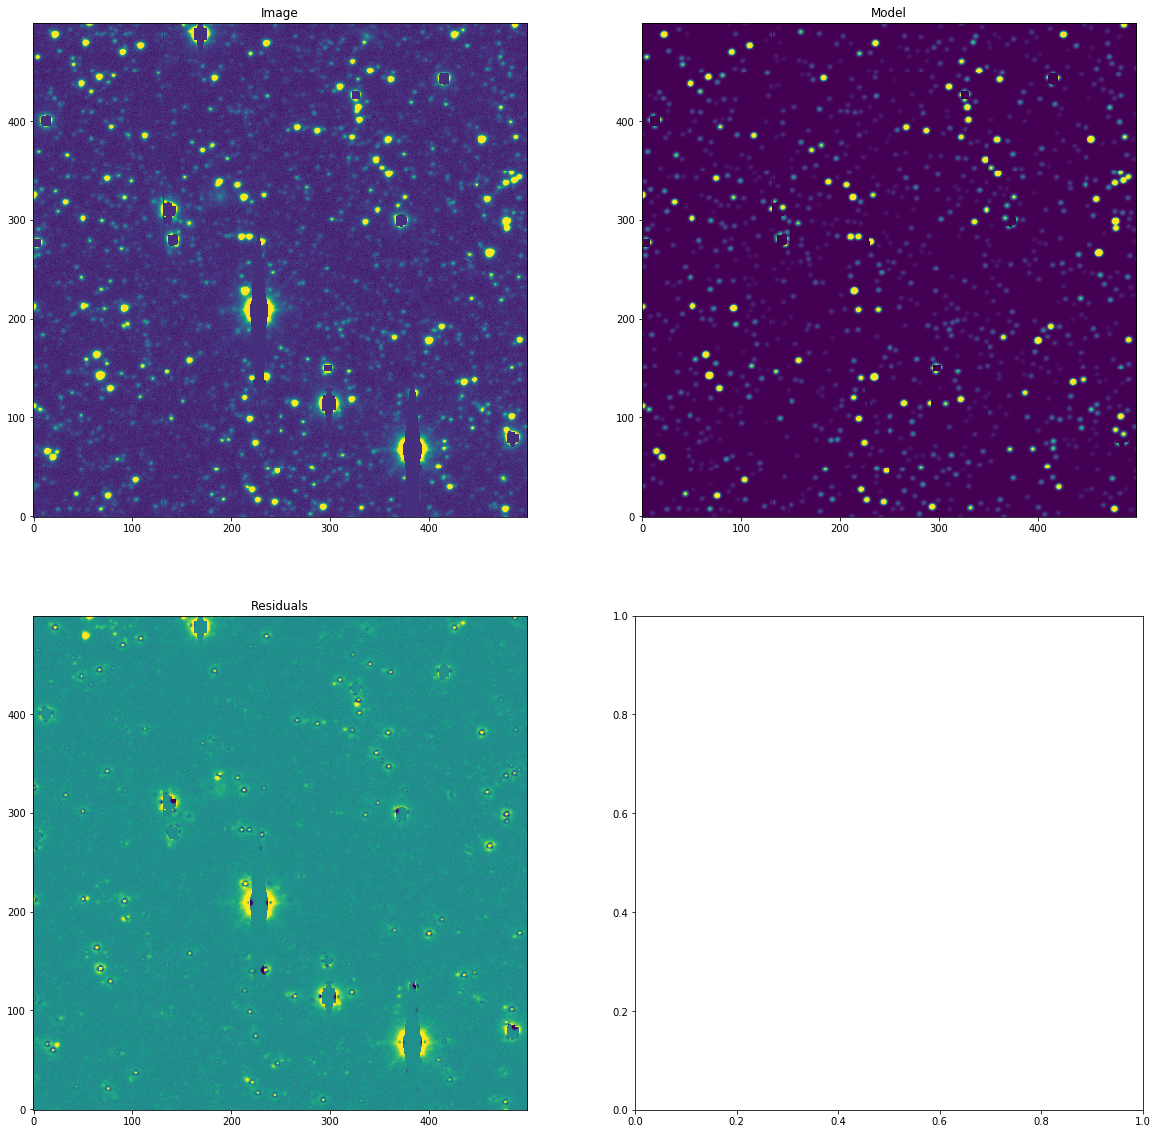

In [34]:
fig, axes = plt.subplots(2,2, figsize=(20, 20))
axes[0,0].imshow(image.data, interpolation='none', origin='lower',vmax=8000)
axes[0,0].set_title("Image")
axes[0,1].imshow(model.data, interpolation='none', origin='lower',vmax=2000)
axes[0,1].set_title("Model")
axes[1,0].imshow(image.data-image.sky-model.data, interpolation='none', origin='lower',vmin=-1000,vmax=1000)
axes[1,0].set_title("Residuals")

### If we zoom in we can see that the PSF is not fitting well in the very center and in the wings

(0, 100)

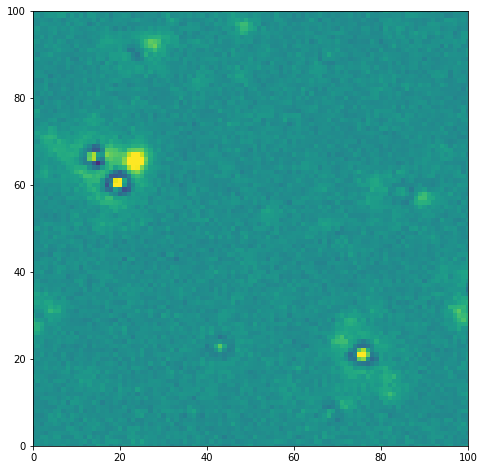

In [35]:
fig = plt.figure(figsize=(8,8))
plt.imshow(image.data-image.sky-model.data, interpolation='none', origin='lower',vmin=-1000,vmax=1000)
plt.xlim(0,100)
plt.ylim(0,100)

## We can improve the fit by using a Penny function which fits the wings better

<font color='blue'>
    <h1>In-class Exercise:</h1>

1) Run ``prometheus.run()`` again with ``penny``.

2) Remake the 3-panel plot and see if the fit is better.
</font>

In [36]:
from prometheus import prometheus
out,model,sky,psf = prometheus.run(image,'penny',verbose=True)

Step 1: Detection
1102 objects detected
Step 2: Aperture photometry
Min/Max mag: 10.93, 17.51
Step 3: Estimate FWHM
FWHM =  4.15 pixels (99 sources)
Step 3: Pick PSF stars
Too few PSF stars on first try. Loosening cuts
62 PSF stars found
Step 4: Construct PSF
Final PSF: PSFPenny([1.4342205568681305, 1.2571311346758405, 0.2363123603276818, 0.26371037291363414, 3.5],binned=False)
Median RMS:  0.0706
Step 5: Get PSF photometry for all objects


/Users/nidever/projects/prometheus/prometheus/groupfit.py:939: RuntimeWarning: invalid value encountered in sqrt
  perror = np.sqrt(np.diag(cov))


dt =  11.559874057769775


Text(0.5, 1.0, 'Residuals')

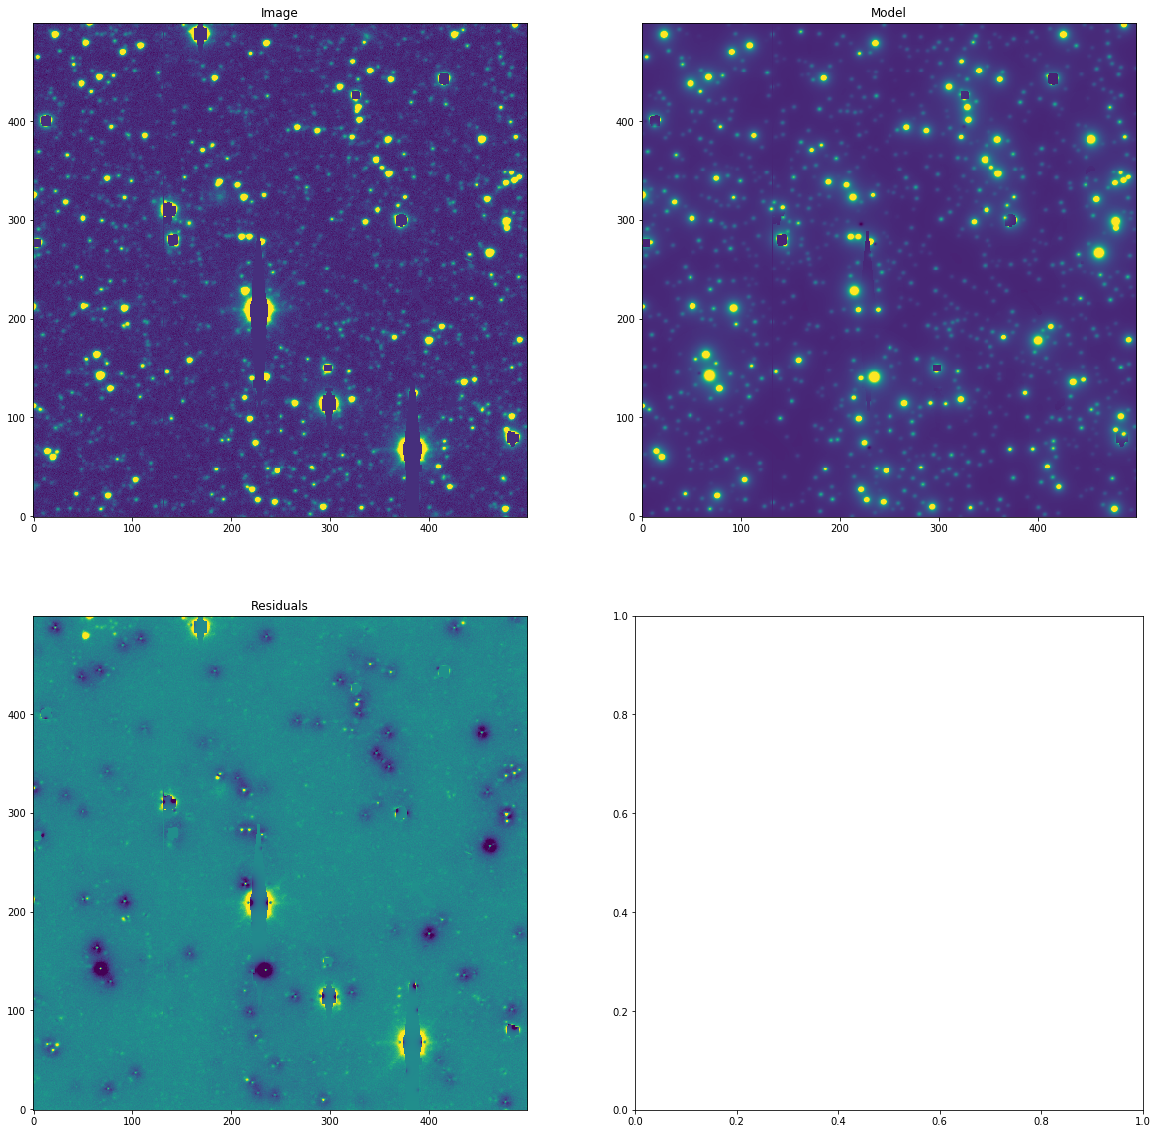

In [37]:
fig, axes = plt.subplots(2,2, figsize=(20, 20))
axes[0,0].imshow(image.data, interpolation='none', origin='lower',vmax=8000)
axes[0,0].set_title("Image")
axes[0,1].imshow(model.data, interpolation='none', origin='lower',vmax=2000)
axes[0,1].set_title("Model")
axes[1,0].imshow(image.data-image.sky-model.data, interpolation='none', origin='lower',vmin=-1000,vmax=1000)
axes[1,0].set_title("Residuals")

# Isochrone Fitting

Load the NGC104 Gaia EDR3 photometry. A proper motion cut has been applied to try to remove non-cluster stars in the foreground.


In [4]:
# Load the NGC104 Gaia EDR3 photometry
# A proper motion
data = fits.getdata('NGC104_photometry.fits')

Make the color-magnitude diagram.  GMAG vs. BP-RP

(22, 10)

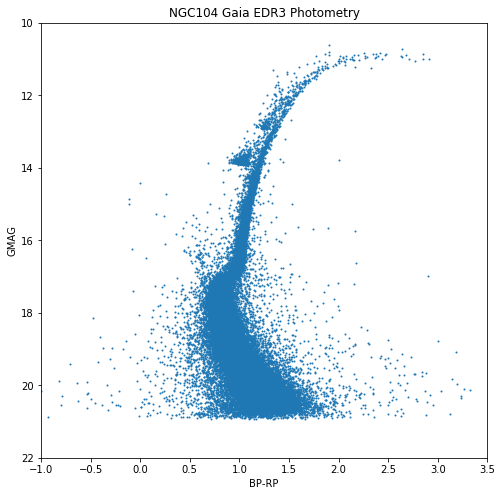

In [17]:
fig = plt.figure(figsize=(8,8))
plt.scatter(data['BP']-data['RP'],data['GMAG'],s=1)
plt.xlabel('BP-RP')
plt.ylabel('GMAG')
plt.title('NGC104 Gaia EDR3 Photometry')
plt.xlim(-1,3.5)
plt.ylim(22,10)

(22, 10)

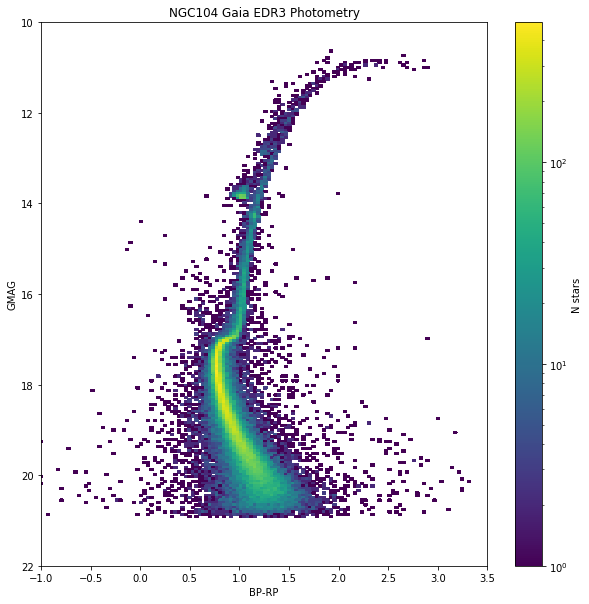

In [27]:
fig = plt.figure(figsize=(10,10))
plt.hist2d(data['BP']-data['RP'],data['GMAG'],bins=(200,200),norm = mpl.colors.LogNorm())
plt.colorbar(label='N stars')
plt.xlabel('BP-RP')
plt.ylabel('GMAG')
plt.title('NGC104 Gaia EDR3 Photometry')
plt.xlim(-1,3.5)
plt.ylim(22,10)

<font color='blue'>
    <h1>In-class Exercise:</h1>

1) Compare all six isochrones to the NGC104 data, vary distance modulus for each.

</font>

<font color='blue'>
    <h1>In-class Exercise:</h1>

Now let's also vary extinction.

Extinction Coefficients:
    
- A(BP)/A(V) = 1.08337	

- A(RP)/A(V) = 0.63439

- A(GMAG)/A(V) = 0.83627	
    
1) Write a little function that dereddenes the photometry given a certain amount of A(V) extinction.
    
2) Redo the fitting but vary extinction as well.
    
    
</font>

<font color='blue'>
    <h1>In-class Exercise:</h1>

1) Use ``chronos.fit()`` to fit the isochrone.
</font>

In [7]:
catnames = ['BP','RP','GMAG']
isonames = ['GAIAEDR3_GBPMAG','GAIAEDR3_GRPMAG','GAIAEDR3_GMAG']
out = chronos.fit(data,catnames=catnames,isonames=isonames,verbose=True)

Fitting isochrones to catalog of 75190 sources
Photometry columns: BP, RP, GMAG
Isochrone columns: GAIAEDR3_GBPMAG, GAIAEDR3_GRPMAG, GAIAEDR3_GMAG
 
Performing grid search
 
Performing maximum likelihood estimation
Age    =  7400000000.00 +/- 116242245.572 years
Metal  =     -1.05 +/-  0.008 dex  
Extinction =      0.42 +/-  0.012      
Distmod =     13.49 +/-  0.021      
 
Final parameters:
Age    =  7400000000.00 +/- 116242245.572 years
Metal  =     -1.05 +/-  0.008 dex  
Extinction =      0.42 +/-  0.012      
Distmod =     13.49 +/-  0.021      
chisq = 5017.79
